# Identifying Spam Mails
we were recently hired in start up company and you were asked to build a system to identify spam emails

In [34]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
#from sklearn.utils import s1804
from collections import Counter

import matplotlib.pyplot as plt

from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.stem import WordNetLemmatizer

from nltk.tokenize import word_tokenize
import gensim
from gensim.utils import simple_preprocess

from gensim.parsing.preprocessing import STOPWORDS

from nltk.stem import WordNetLemmatizer, SnowballStemmer
#from nltk.stem import *
import numpy as np
np.random.seed(400)
import nltk
#nltk.download('vader_lexicon')
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [35]:
df= pd.read_csv('messages.csv')

In [36]:
df.head(5)

subject  \
0            job posting - apple-iss research center   
1                                                NaN   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   

                                             message  label  
0  content - length : 3386 apple-iss research cen...      0  
1  lang classification grimes , joseph e . and ba...      0  
2  i am posting this inquiry for sergei atamas ( ...      0  
3  a colleague and i are researching the differin...      0  
4  earlier this morning i was on the phone with a...      0

In [37]:
print(df.size)
print(df.shape)
print(df.dtypes)

8679
(2893, 3)
subject    object
message    object
label       int64
dtype: object


In [38]:
df.describe()

label
count  2893.000000
mean      0.166263
std       0.372381
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000

In [39]:
df.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [40]:
df.message[10]

'groningen assembly on language acquisition 1995 university of groningen the netherlands 7 - 9 september 1995 the conference aims to bring together researchers willing to discuss the merits and constraints of different theoretical approaches to language acquisition , in particular generative linguistics , constructionism , dynamic systems modelling , and connectionism . invited speakers harald clahsen university of essex annette karmiloff - smith mrc london kim plunkett university of oxford luigi rizzi university of geneva paul van geert university of groningen abstract submissions abstracts may cover all aspects of language acquisition relating to the core areas of linguistics , including phonology , morphology , syntax , semantics and the interfaces . selection of abstracts will be based on not only their quality but also their potential to contribute to the conference \'s interactive objective . abstract submissions should include : 1 . five ( 5 ) copies of a one-page , double-space

In [42]:
#Ratio
print ('spam ratio = ', round(len(df[df['label']==1]) / len(df.label),2)*100,'%')
print ('ham ratio  = ', round(len(df[df['label']==0]) / len(df.label),2)*100,'%')

spam ratio =  17.0 %
ham ratio  =  83.0 %


In [43]:
df['length']=df.message.str.len()

# Feature engineering
lower the text

tokenize the text (split the text into words) and remove the punctuation

remove useless words that contain numbers

remove useless stop words like 'the', 'a' ,'this' etc.

Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database

In [77]:
df['message']=df['message'].str.lower()

In [46]:
# Replace email addresses with 'email'
df['message1'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
df['message1'] = df['message1'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['message1'] = df['message1'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['message1'] = df['message1'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')

    
# Replace numbers with 'numbr'
df['message1'] = df['message1'].str.replace(r'\d+(\.\d+)?', 'numbr')
# Remove punctuation
df['message1'] = df['message1'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['message1'] = df['message1'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['message1'] = df['message1'].str.replace(r'^\s+|\s+?$_+\_', '')

In [48]:
analyser = SentimentIntensityAnalyzer()
df['neu']=df['message1'].apply(lambda x: analyser.polarity_scores(x)['neu'])
df['pos']=df['message1'].apply(lambda x: analyser.polarity_scores(x)['pos'])
df['compound']=df['message1'].apply(lambda x: analyser.polarity_scores(x)['compound'])
df['neg']=df['message1'].apply(lambda x: analyser.polarity_scores(x)['neg'])

In [76]:
df.head(5)

subject  \
0            job posting - apple-iss research center   
1                                                NaN   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   

                                             message  label  length  \
0  content - length : 3386 apple-iss research cen...      0    2856   
1  lang classification grimes , joseph e . and ba...      0    1800   
2  i am posting this inquiry for sergei atamas ( ...      0    1435   
3  a colleague and i are researching the differin...      0     324   
4  earlier this morning i was on the phone with a...      0    1046   

                                            message1    neu    pos  compound  \
0  content length numbr apple iss research center...  0.893  0.107    0.9873   
1  lang classification grimes joseph e barbara f ...  0.959  0.017   -0.3657   
2  posting inquiry sergei atamas satamas umabnet ...  0.934  0.066    0.9217   
3  colleague researching differing degrees risk p...  0.839  0.091    0.2960   
4  earlier morning phone friend mine living south...  0.873  0.082    0.5994   

     neg                                              words  clean_length  
0  0.000  [content, length, numbr, apple, iss, research,...          2179  
1  0.023  [lang, classification, grimes, joseph, e, and,...          1454  
2  0.000  [i, am, posting, this, inquiry, for, sergei, a...          1064  
3  0.070  [a, colleague, and, i, are, researching, the, ...           210  
4  0.045  [earlier, this, morning, i, was, on, the, phon...           629

In [49]:
df['words']=df['message1'].apply(lambda x: x.split(' '))

In [50]:
df

subject  \
0               job posting - apple-iss research center   
1                                                   NaN   
2     query : letter frequencies for text identifica...   
3                                                  risk   
4                              request book information   
5     call for abstracts : optimality in syntactic t...   
6                   m . a . in scandinavian linguistics   
7     call for papers : linguistics session of the m...   
8                       foreign language in commercials   
9     fulbright announcement : please post / dissemi...   
10                          gala ' 95 : call for papers   
11    bu conf on language development ' 95 - announc...   
12                        korean software for macintosh   
13                                                  NaN   
14    simultaneous prepositions and postpositions in...   
15               sum : imperatives without you subjects   
16                                             policies   
17    * * * correction to hellenistic greek announce...   
18                            question on audio samples   
19                                  sexism and language   
20                            teaching english in korea   
21                                                 free   
22                       email address for w . dressler   
23    dhumbadji ! , journal for the history of language   
24                  question : quantitative information   
25                                         re : amharic   
26                                    uniformitarianism   
27          re : 6 . 1094 , qs : phonemicity of writing   
28           intensive summer arabic language institute   
29                      lists on comparative literature   
...                                                 ...   
2863                                  summary : even if   
2864  re : 6 . 797 , comparative method : n - ary co...   
2865                    q : incorporation in mandarin ?   
2866                                   wholesale club !   
2867                    re : call me now 732-942 - 7100   
2868                       http : / / www . xxxnet . cx   
2869  summary of responses to query on tok masta ( f...   
2870                   this is new on 95 . 8 capital fm   
2871                                sum : verbal humour   
2872       subcategorization in tranformational grammar   
2873                                parsers for russian   
2874                                case studies needed   
2875  re : 8 . 1107 , qs : lang . games , " democrat...   
2876  indoeuropean courses listed by universities ( ...   
2877                   job : indonesian / asian studies   
2878  re : 6 . 797 , comparative method : n - ary co...   
2879                  summary : heavy onsets references   
2880                         sum master 's dissertation   
2881                              internships in israel   
2882    accept credit cards and watch sales skyrocket !   
2883                          evolvable hardware and gp   
2884                 did that work for you ? - calsvxtn   
2885                    british vs . american < a > ( s   
2886                      from fanny , recommending nek   
2887                        win $ 300usd and a cruise !   
2888                       love your profile - ysuolvpv   
2889                 you have been asked to join kiddin   
2890                 anglicization of composers ' names   
2891  re : 6 . 797 , comparative method : n - ary co...   
2892               re : american - english in australia   

                                                message  label  length  \
0     content - length : 3386 apple-iss research cen...      0    2856   
1     lang classification grimes , joseph e . and ba...      0    1800   
2     i am posting this inquiry for sergei atamas ( ...      0    1435   
3     a colleague and i are researching the differin...      0     324   
4     earlier this 

# Building word dictionary

In [47]:
#df['message1']=df['message1'].apply(lambda x: nltk.sent_tokenize(x))

In [51]:
#!pip install gensim

stemmer = SnowballStemmer("english")
# Converts into tokens (Alternative to word_tokenize)

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token)>3:
            result.append(lemmatize_stemming(token))
            
    return result

In [52]:
processed_docs = []

for doc in df.message1:
    processed_docs.append(preprocess(doc))

In [53]:
print(processed_docs[:4])

[['content', 'length', 'numbr', 'appl', 'research', 'center', 'doller', 'numbr', 'million', 'joint', 'ventur', 'appl', 'institut', 'system', 'scienc', 'nation', 'univers', 'singapor', 'locat', 'singapor', 'look', 'senior', 'speech', 'scientist', 'success', 'candid', 'research', 'expertis', 'comput', 'linguist', 'includ', 'natur', 'languag', 'process', 'english', 'chines', 'statist', 'languag', 'model', 'knowledg', 'state', 'corpus', 'base', 'gram', 'languag', 'model', 'cach', 'languag', 'model', 'speech', 'languag', 'model', 'requir', 'text', 'speech', 'project', 'leader', 'success', 'candid', 'research', 'expertis', 'expertis', 'follow', 'area', 'comput', 'linguist', 'includ', 'natur', 'languag', 'pars', 'lexic', 'databas', 'design', 'statist', 'languag', 'model', 'text', 'token', 'normal', 'prosod', 'analysi', 'substanti', 'knowledg', 'phonolog', 'syntax', 'semant', 'chines', 'requir', 'knowledg', 'acoust', 'phonet', 'speech', 'signal', 'process', 'desir', 'candid', 'numbr', 'numbr',

In [54]:
dictionary = gensim.corpora.Dictionary(processed_docs)
print (dictionary)
count=0
for k,v in dictionary.iteritems():
    print (k, v)
    count +=1
    if count >15:
        break
dictionary.filter_extremes(no_below=15,no_above=0.1,keep_n=100000)

Dictionary(39803 unique tokens: ['acoust', 'advantag', 'analysi', 'appl', 'appli']...)
0 acoust
1 advantag
2 analysi
3 appl
4 appli
5 area
6 attend
7 base
8 benefit
9 break
10 cach
11 california
12 candid
13 center
14 chines
15 competit


In [55]:
print(dictionary)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
document_num = 2
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]],
                                                     bow_doc_x[i][1]))

Dictionary(3157 unique tokens: ['acoust', 'advantag', 'appl', 'attend', 'benefit']...)
Word 117 ("actual") appears 1 time.
Word 118 ("algorithm") appears 2 time.
Word 119 ("analog") appears 1 time.
Word 120 ("baltimor") appears 1 time.
Word 121 ("biolog") appears 1 time.
Word 122 ("bloomington") appears 1 time.
Word 123 ("collabor") appears 1 time.
Word 124 ("compar") appears 1 time.
Word 125 ("concern") appears 1 time.
Word 126 ("connect") appears 1 time.
Word 127 ("dept") appears 3 time.
Word 128 ("explor") appears 1 time.
Word 129 ("frequenc") appears 3 time.
Word 130 ("georg") appears 2 time.
Word 131 ("identif") appears 1 time.
Word 132 ("indiana") appears 2 time.
Word 133 ("inquiri") appears 1 time.
Word 134 ("involv") appears 1 time.
Word 135 ("letter") appears 3 time.
Word 136 ("literatur") appears 1 time.
Word 137 ("maryland") appears 1 time.
Word 138 ("observ") appears 1 time.
Word 139 ("occur") appears 1 time.
Word 140 ("offic") appears 1 time.
Word 141 ("pass") appears 2 ti

In [56]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)
for idx, topic in lda_model.print_topics():
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer"


Topic: 1 
Words: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi"


Topic: 2 
Words: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl"


Topic: 3 
Words: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money"


Topic: 4 
Words: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact"


Topic: 5 
Words: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 

In [57]:
for i in range(0,2893):
    bow_vector = dictionary.doc2bow(preprocess(df.message[i]))

    for index, score in sorted(lda_model[bow_vector]):
        print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 15)))       

Score: 0.04939335957169533	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.5537356734275818	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.38925883173942566	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.26869043707847595	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dial

Score: 0.30543631315231323	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.18799400329589844	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.1897606998682022	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.4386928081512451	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit

Score: 0.4989560544490814	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.017617184668779373	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.024892183020710945	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.45688971877098083	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar"

Score: 0.5738456845283508	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.13127312064170837	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.2825937271118164	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.3932543098926544	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"ess

Score: 0.7463539242744446	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.22943797707557678	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.02278180979192257	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.12489550560712814	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0

Score: 0.9849910140037537	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9884551763534546	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.016671549528837204	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.016672125086188316	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect

Score: 0.020007498562335968	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.020014794543385506	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.020007174462080002	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.020007960498332977	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.

Score: 0.9775177240371704	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.019848771393299103	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.2163354605436325	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.5348697900772095	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0

Score: 0.15786658227443695	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.8393917083740234	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9294739365577698	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.014482986181974411	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"proj

Score: 0.6638808846473694	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.11152077466249466	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.10502650588750839	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.061539631336927414	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"pro

Score: 0.033979419618844986	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.1452612280845642	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.21538715064525604	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.31034931540489197	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*

Score: 0.13428255915641785	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.6559426188468933	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.15531709790229797	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.05288208648562431	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0

Score: 0.9918131828308105	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.020002257078886032	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.020004410296678543	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.020003708079457283	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"con

Score: 0.501833975315094	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.4560421109199524	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.977491021156311	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.3650754988193512	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summar

Score: 0.9984844923019409	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.5225305557250977	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.4760628640651703	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.36585763096809387	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetow

Score: 0.6656925678253174	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.5854995250701904	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.39588579535484314	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.36983752250671387	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million

Score: 0.9954971671104431	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.40464693307876587	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.5924940705299377	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.05363788083195686	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgeto

Score: 0.06246262416243553	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.3534875214099884	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5747110247612	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.0478714182972908	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" 

Score: 0.5891345143318176	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.03726061433553696	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.37172210216522217	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.8290165066719055	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"direct

Score: 0.9356932044029236	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.9399868845939636	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.8820602893829346	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.08155030012130737	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japane

Score: 0.15857656300067902	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.1377192586660385	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.07286309450864792	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.6294828653335571	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"p

Score: 0.9869506359100342	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.6371591091156006	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.3536413013935089	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.9243772029876709	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"a

Score: 0.020005421712994576	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.020005423575639725	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.02000591903924942	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.020008906722068787	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" 

Score: 0.32683852314949036	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.15096069872379303	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5201286673545837	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9437368512153625	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.

Score: 0.530344545841217	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.04634995758533478	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.12094901502132416	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.8290159702301025	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" 

Score: 0.11497404426336288	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.7947404384613037	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.08857709914445877	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.5416145324707031	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"jo

Score: 0.3462876081466675	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.44920164346694946	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.1870022416114807	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.05288219451904297	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.0

Score: 0.7508233785629272	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.0649472177028656	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.17786277830600739	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.2940100431442261	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 

Score: 0.03896321728825569	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.6880908608436584	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.27001506090164185	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.012503297999501228	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*

Score: 0.08248157799243927	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.8867302536964417	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.0944780632853508	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.5887695550918579	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"socia

Score: 0.539810836315155	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.4575560688972473	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.26649540662765503	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.20127135515213013	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directo

Score: 0.4340985119342804	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.5521050691604614	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.15548865497112274	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.14612148702144623	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.0

Score: 0.30048492550849915	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.5750122666358948	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.09532192349433899	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.918161153793335	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"co

Score: 0.9884566068649292	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9816250801086426	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.08402399718761444	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.330303817987442	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" 

Score: 0.018725993111729622	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.3082139194011688	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.670807957649231	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9411342740058899	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"cons

Score: 0.7993015646934509	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.07545012980699539	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.09735903143882751	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.026575613766908646	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*

Score: 0.416415274143219	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.3667692244052887	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.11681392043828964	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9356806874275208	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mou

Score: 0.934468686580658	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.06202102452516556	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.36394938826560974	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.6220057606697083	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005

Score: 0.12825392186641693	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.0852217897772789	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.5394303202629089	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.23959064483642578	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0

Score: 0.026348434388637543	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.9702601432800293	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9695265889167786	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.028119293972849846	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007

Score: 0.12763066589832306	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.7858951091766357	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.039327412843704224	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.04533478617668152	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0

Score: 0.34261393547058105	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.23054103553295135	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.07276436686515808	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.24652521312236786	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"pro

Score: 0.9676262736320496	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.024036020040512085	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.10190474987030029	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.722415566444397	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.0

Score: 0.1474539190530777	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.6391101479530334	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.2117065042257309	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.2751592695713043	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dia

Score: 0.11494912952184677	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.1262599378824234	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.2161710560321808	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.46022269129753113	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*

Score: 0.8166965246200562	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.01225185301154852	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.125511035323143	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.04320453479886055	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"

Score: 0.02182447724044323	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.7525927424430847	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.030733386054635048	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.21811528503894806	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 

Score: 0.3933883011341095	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.05362315848469734	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.5448455214500427	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.23079201579093933	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouto

Score: 0.5009934902191162	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.04242286458611488	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.17712661623954773	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.12431997060775757	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"pro

Score: 0.513441264629364	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.4783082902431488	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9873209595680237	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.9117911458015442	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 

Score: 0.07920875400304794	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.73795086145401	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.18043366074562073	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.9307600259780884	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 

Score: 0.252978652715683	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.7373775839805603	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9426968097686768	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.03990201652050018	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*

Score: 0.4909721314907074	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.49914705753326416	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.2845773696899414	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.40953171253204346	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar"

Score: 0.36503109335899353	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.13214345276355743	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.2569340467453003	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.36329764127731323	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dia

Score: 0.4296967089176178	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.5369569659233093	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.4167715311050415	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.38972708582878113	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" +

Score: 0.993614912033081	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.7089816331863403	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.2750104069709778	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.47257906198501587	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialec

Score: 0.6811133027076721	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.31596559286117554	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.3075912296772003	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.5821928977966309	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"soc

Score: 0.5613221526145935	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.4090404212474823	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.7363027334213257	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.24368639290332794	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 

Score: 0.38769403100013733	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.43676090240478516	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.1666790097951889	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.8703068494796753	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"

Score: 0.985933244228363	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.21836456656455994	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.7722204923629761	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.0819213017821312	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conso

Score: 0.011114071123301983	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.011115680448710918	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.01111435703933239	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.011115780100226402	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" 

Score: 0.9833287000656128	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.8686977624893188	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.06845033168792725	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.05407312512397766	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.00

Score: 0.6942896842956543	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.25236618518829346	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.9181520938873291	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.640230655670166	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summa

Score: 0.873322606086731	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.12141162902116776	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.6394059062004089	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.35756221413612366	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"clot

Score: 0.026888012886047363	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.20557831227779388	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.3544677197933197	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.09696705639362335	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"r

Score: 0.35536202788352966	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.13510408997535706	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.36872124671936035	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.12458743900060654	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist

Score: 0.04582039639353752	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.08801973611116409	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.08907192200422287	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.576275646686554	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" 

Score: 0.4906446933746338	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.42094114422798157	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.08371378481388092	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.02000640332698822	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton

Score: 0.1253538876771927	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.11389941722154617	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.18528950214385986	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7993208169937134	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"res

Score: 0.26821169257164	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.44608110189437866	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.20619256794452667	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.07682235538959503	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.00

Score: 0.6824225187301636	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.9666580557823181	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.3194672465324402	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.034053631126880646	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.00

Score: 0.6111470460891724	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.23979638516902924	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.14732293784618378	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.01111577544361353	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" 

Score: 0.07396069169044495	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.918140172958374	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.06432966142892838	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.06914865970611572	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth"

Score: 0.08617055416107178	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9064189791679382	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.6251274943351746	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.31627869606018066	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask

Score: 0.1435229629278183	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.020988022908568382	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.2526141405105591	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.017810333520174026	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal

Score: 0.9985095858573914	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.010005122981965542	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.19907496869564056	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.7208819389343262	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"c

Score: 0.27181142568588257	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.22033743560314178	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.042657095938920975	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.7352458834648132	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"

Score: 0.9984121322631836	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.98347008228302	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9742692112922668	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.27237576246261597	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.00

Score: 0.08552966266870499	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.908314049243927	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.3641503155231476	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.626433253288269	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 

Score: 0.8256613612174988	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.16053234040737152	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.27787908911705017	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.30886560678482056	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar"

Score: 0.12183988094329834	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.8762854933738708	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.1345367282629013	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.4796605110168457	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" +

Score: 0.057778842747211456	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.06424184143543243	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.38029733300209045	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.496502548456192	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 

Score: 0.027370572090148926	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.9138327836990356	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.05808054283261299	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.13878507912158966	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal"

Score: 0.06478764116764069	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.31707778573036194	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.47336578369140625	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.1329948902130127	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase"

Score: 0.23763468861579895	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.09359760582447052	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.05438229441642761	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.10892161726951599	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"ph

Score: 0.9974128603935242	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.3498443365097046	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.10857149958610535	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.07733803987503052	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price

Score: 0.08381473273038864	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7269458174705505	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.16538706421852112	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.022736450657248497	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" +

Score: 0.45261043310165405	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5451285243034363	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.15811915695667267	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.16490259766578674	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar

Score: 0.18373820185661316	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.8117398619651794	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.22897112369537354	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.6081905364990234	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*

Score: 0.9937482476234436	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.03710699826478958	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9593020081520081	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9819931387901306	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0

Score: 0.16904212534427643	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.6135766506195068	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.16278433799743652	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.05138632282614708	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 

Score: 0.37620726227760315	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.3570062518119812	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.03335346281528473	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.03334501013159752	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.

Score: 0.07963807135820389	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.17585839331150055	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7429080605506897	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.7241532802581787	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"pri

Score: 0.8225727677345276	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.17594201862812042	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9499773979187012	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.6724738478660583	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"p

Score: 0.9920323491096497	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.9945099949836731	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.8994633555412292	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.09585601091384888	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"ja

Score: 0.033479467034339905	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.5288183093070984	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.43636542558670044	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.06359919160604477	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal"

Score: 0.01111237145960331	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.899978756904602	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.011112554930150509	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.011114275082945824	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*

Score: 0.44606104493141174	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.38863223791122437	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.11298156529664993	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.050413090735673904	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assis

Score: 0.9943370223045349	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.16734841465950012	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.781925618648529	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.04751208424568176	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"acco

Score: 0.9971233606338501	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9965368509292603	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.7102175951004028	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.2497074455022812	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"pr

Score: 0.5898286700248718	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.08372309058904648	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.2930937707424164	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.1355145275592804	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.0

Score: 0.07895978540182114	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.08604756742715836	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.22832557559013367	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5995196104049683	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 

Score: 0.4324498772621155	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.03613729029893875	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.17715291678905487	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.35257792472839355	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"proj

Score: 0.08392864465713501	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.6241523623466492	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.2879161536693573	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.1602213829755783	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 

Score: 0.4210341274738312	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.03287573903799057	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9964966177940369	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.9906203746795654	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0

Score: 0.04100001975893974	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.22068029642105103	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.4826817214488983	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.2511241137981415	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0

Score: 0.9470428824424744	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.1575486660003662	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.8317781090736389	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.7114077806472778	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0

Score: 0.012502632103860378	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.01250194851309061	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.887478232383728	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.012504346668720245	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*

Score: 0.9962485432624817	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9852423667907715	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9852423071861267	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9975059032440186	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"direct

Score: 0.04004920646548271	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.948676586151123	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.724624514579773	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.16820549964904785	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"pro

Score: 0.7268749475479126	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.2564508020877838	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.9919334650039673	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.5189772844314575	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"cons

Score: 0.01767999865114689	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.11166759580373764	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.866926908493042	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.5949268341064453	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"

Score: 0.39983680844306946	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.1448301523923874	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.4516471028327942	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.949980616569519	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 

Score: 0.8491722941398621	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.14069391787052155	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.9961026310920715	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9699762463569641	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softw

Score: 0.3179597854614258	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.3704512119293213	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.308189332485199	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.3217363953590393	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar

Score: 0.11418207734823227	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.2620445191860199	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.6182149648666382	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.01000539492815733	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton"

Score: 0.9987460970878601	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.9799908995628357	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.21693432331085205	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.7746409177780151	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"j

Score: 0.751993715763092	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.24570631980895996	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.9960342049598694	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7925075888633728	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" 

Score: 0.7705051302909851	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.2206009477376938	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.1310809701681137	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.8654077649116516	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" 

Score: 0.025604242458939552	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.36169642210006714	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.14841604232788086	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.41118481755256653	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"projec

Score: 0.053202494978904724	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.09372578561306	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.8002796769142151	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.05018173158168793	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0

Score: 0.15734972059726715	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.43104755878448486	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.39603596925735474	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.27112963795661926	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0

Score: 0.9165019989013672	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.05700024589896202	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.6045020222663879	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.33062872290611267	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod

Score: 0.08487813919782639	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.38653722405433655	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.5096506476402283	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.35900241136550903	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit

Score: 0.8794724941253662	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.07233291119337082	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.7998946905136108	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.15798284113407135	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.

Score: 0.9923699498176575	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9398372769355774	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.029108090326189995	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.02579713799059391	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010

Score: 0.12810246646404266	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.4994840621948242	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.34739431738853455	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.525693416595459	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.00

Score: 0.9938738942146301	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.3152937591075897	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.3266584575176239	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.34774869680404663	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.00

Score: 0.42409899830818176	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.5438764095306396	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.736266016960144	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.10196154564619064	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compa

Score: 0.6493893265724182	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.0866091400384903	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.14046157896518707	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.11813154071569443	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.0

Score: 0.43679293990135193	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.5588809251785278	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5700164437294006	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.4284592568874359	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"sof

Score: 0.18809497356414795	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.038870133459568024	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7715817093849182	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.2668594717979431	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" 

Score: 0.15909509360790253	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.11248516291379929	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.7188274264335632	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.08356249332427979	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"ca

Score: 0.9978358745574951	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.3515290319919586	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.08669157326221466	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.5384331345558167	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.00

Score: 0.992497980594635	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.08806253224611282	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.5332643985748291	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.3683738112449646	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 

Score: 0.9909967184066772	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.7340067028999329	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.2519528269767761	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.8827455043792725	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 

Score: 0.033348020166158676	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.033343106508255005	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.03334933891892433	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.03335213288664818	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" +

Score: 0.6568219065666199	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.3317433297634125	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.010000855661928654	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.010001405142247677	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialec

Score: 0.763862133026123	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.13151653110980988	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.09910593926906586	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.47635143995285034	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"d

Score: 0.6451754570007324	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.35086116194725037	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9849929213523865	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.2724244296550751	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"c

Score: 0.7767775058746338	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.9010471701622009	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.08942512422800064	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.8063352108001709	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 

Score: 0.8499217629432678	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.016674751415848732	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.01667463406920433	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.0166734978556633	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"inte

Score: 0.07446625083684921	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.034496888518333435	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.888480544090271	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.8598209619522095	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect"

Score: 0.9790565967559814	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.08157946914434433	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.01507390383630991	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.1667262762784958	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.0

Score: 0.2759418785572052	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.17913798987865448	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.15961214900016785	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.08009935170412064	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 

Score: 0.9944082498550415	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.4840225279331207	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.5021767616271973	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9073906540870667	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"as

Score: 0.9819934368133545	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.37090614438056946	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.6165755987167358	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.09776806831359863	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.00

Score: 0.39069896936416626	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.6082892417907715	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.9499823451042175	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.4515577554702759	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 

Score: 0.08845841139554977	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.8232547044754028	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.08567336946725845	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.9437339901924133	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*

Score: 0.12285853177309036	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7887558937072754	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.5338565707206726	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.22026515007019043	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 

Score: 0.2356865555047989	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.4004109501838684	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.234239861369133	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.0717727541923523	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.00

Score: 0.33480000495910645	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.24904493987560272	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.40554219484329224	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.8481289148330688	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.00

Score: 0.062052756547927856	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.47106924653053284	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.2834322452545166	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.03993955999612808	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal"

Score: 0.5982943773269653	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.05463442578911781	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.3435869812965393	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.014288606122136116	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"

Score: 0.44370073080062866	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.798062264919281	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.1776871532201767	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.2011503279209137	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0

Score: 0.25938931107521057	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.7005967497825623	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.9881538152694702	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.32206180691719055	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"con

Score: 0.07937654852867126	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.6304991841316223	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.1280248761177063	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.37468820810317993	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"co

Score: 0.23931413888931274	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.7532058954238892	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.06171411648392677	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9339129328727722	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phra

Score: 0.07025497406721115	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.6448487639427185	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.2838783264160156	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.6058807969093323	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.

Score: 0.5170918703079224	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.10351703315973282	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.10404402017593384	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.1245366632938385	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 

Score: 0.9980079531669617	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.09930814057588577	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.6657834053039551	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.22823849320411682	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"acc

Score: 0.8043034672737122	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.09182234853506088	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.23177964985370636	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.7511897087097168	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 

Score: 0.2930932939052582	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7059707641601562	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.18946465849876404	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.06187628209590912	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004

Score: 0.22960112988948822	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.050673894584178925	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.4025720953941345	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.30437925457954407	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal

Score: 0.9857094287872314	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.19565069675445557	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.7869477272033691	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9749932885169983	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" 

Score: 0.9952870011329651	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.2496201992034912	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.7033056616783142	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.4782164990901947	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.

Score: 0.989883303642273	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9896525144577026	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.022727664560079575	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.5127647519111633	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.00

Score: 0.2981296479701996	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.70091313123703	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.8912152051925659	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.10486161708831787	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"

Score: 0.09388100355863571	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.4181680381298065	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.2675704061985016	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.022184547036886215	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"proj

Score: 0.03655586019158363	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.6808673143386841	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.28116756677627563	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.2910482883453369	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"mi

Score: 0.8773483633995056	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.11255807429552078	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.24483029544353485	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7508442401885986	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"pric

Score: 0.993567943572998	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.09526475518941879	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.08145886659622192	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.19148728251457214	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"ass

Score: 0.8922914862632751	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.10531918704509735	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.33106186985969543	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.6553686261177063	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"ja

Score: 0.24483884871006012	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7508357763290405	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.8194926977157593	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.17151838541030884	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth

Score: 0.16522295773029327	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.6714257001876831	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.15148042142391205	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.08191455900669098	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"

Score: 0.9766412973403931	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.021104248240590096	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.39731720089912415	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.5878555774688721	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004

Score: 0.9951063990592957	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.3972533643245697	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.09233037382364273	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.20749711990356445	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"res

Score: 0.01250450313091278	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.39919325709342957	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.012504915706813335	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.012504746206104755	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"i

Score: 0.313828706741333	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.24788281321525574	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.16195781528949738	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.26791656017303467	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" 

Score: 0.41549137234687805	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.854396641254425	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.12699033319950104	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.5094417929649353	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" 

Score: 0.053631141781806946	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.8762398362159729	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.11466413736343384	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.5717359781265259	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.

Score: 0.45926812291145325	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.02389848418533802	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.5119010210037231	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.9718615412712097	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"diale

Score: 0.32755953073501587	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.40240752696990967	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.2679041028022766	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9249674677848816	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 

Score: 0.20820115506649017	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.05776409059762955	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.16697387397289276	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.7735864520072937	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase

Score: 0.01429277379065752	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.014295483939349651	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.014296835288405418	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.014293897897005081	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"

Score: 0.9100323915481567	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.07869492471218109	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.5467352867126465	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.27391037344932556	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"proje

Score: 0.21018901467323303	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.7871066331863403	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.08981233090162277	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.19279026985168457	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dia

Score: 0.0644356831908226	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.35342010855674744	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.41858309507369995	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.07066763192415237	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.

Score: 0.2257108986377716	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.42576512694358826	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.3377481698989868	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.19880330562591553	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.00

Score: 0.03334224969148636	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.033371999859809875	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.03334040194749832	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.09970856457948685	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*

Score: 0.5623296499252319	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.3876488506793976	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.012502876110374928	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.012503459118306637	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*

Score: 0.4062722325325012	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.08621932566165924	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.38489842414855957	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.26497623324394226	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson"

Score: 0.0111120929941535	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.011112835258245468	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.011112227104604244	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.5716922879219055	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" 

Score: 0.13094887137413025	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.8607143759727478	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9249518513679504	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.010001394897699356	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"es

Score: 0.7811329960823059	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.2157151699066162	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.1681138426065445	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.8207699060440063	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" +

Score: 0.3878849744796753	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.24271605908870697	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.3619466722011566	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.01000139582902193	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mo

In [58]:
df

subject  \
0               job posting - apple-iss research center   
1                                                   NaN   
2     query : letter frequencies for text identifica...   
3                                                  risk   
4                              request book information   
5     call for abstracts : optimality in syntactic t...   
6                   m . a . in scandinavian linguistics   
7     call for papers : linguistics session of the m...   
8                       foreign language in commercials   
9     fulbright announcement : please post / dissemi...   
10                          gala ' 95 : call for papers   
11    bu conf on language development ' 95 - announc...   
12                        korean software for macintosh   
13                                                  NaN   
14    simultaneous prepositions and postpositions in...   
15               sum : imperatives without you subjects   
16                                             policies   
17    * * * correction to hellenistic greek announce...   
18                            question on audio samples   
19                                  sexism and language   
20                            teaching english in korea   
21                                                 free   
22                       email address for w . dressler   
23    dhumbadji ! , journal for the history of language   
24                  question : quantitative information   
25                                         re : amharic   
26                                    uniformitarianism   
27          re : 6 . 1094 , qs : phonemicity of writing   
28           intensive summer arabic language institute   
29                      lists on comparative literature   
...                                                 ...   
2863                                  summary : even if   
2864  re : 6 . 797 , comparative method : n - ary co...   
2865                    q : incorporation in mandarin ?   
2866                                   wholesale club !   
2867                    re : call me now 732-942 - 7100   
2868                       http : / / www . xxxnet . cx   
2869  summary of responses to query on tok masta ( f...   
2870                   this is new on 95 . 8 capital fm   
2871                                sum : verbal humour   
2872       subcategorization in tranformational grammar   
2873                                parsers for russian   
2874                                case studies needed   
2875  re : 8 . 1107 , qs : lang . games , " democrat...   
2876  indoeuropean courses listed by universities ( ...   
2877                   job : indonesian / asian studies   
2878  re : 6 . 797 , comparative method : n - ary co...   
2879                  summary : heavy onsets references   
2880                         sum master 's dissertation   
2881                              internships in israel   
2882    accept credit cards and watch sales skyrocket !   
2883                          evolvable hardware and gp   
2884                 did that work for you ? - calsvxtn   
2885                    british vs . american < a > ( s   
2886                      from fanny , recommending nek   
2887                        win $ 300usd and a cruise !   
2888                       love your profile - ysuolvpv   
2889                 you have been asked to join kiddin   
2890                 anglicization of composers ' names   
2891  re : 6 . 797 , comparative method : n - ary co...   
2892               re : american - english in australia   

                                                message  label  length  \
0     content - length : 3386 apple-iss research cen...      0    2856   
1     lang classification grimes , joseph e . and ba...      0    1800   
2     i am posting this inquiry for sergei atamas ( ...      0    1435   
3     a colleague and i are researching the differin...      0     324   
4     earlier this 

# EDA

In [59]:
import string
import nltk
from nltk.corpus import  stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['message1'] = df['message1'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [60]:
df['clean_length'] = df.message1.str.len()
df.head()

subject  \
0            job posting - apple-iss research center   
1                                                NaN   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   

                                             message  label  length  \
0  content - length : 3386 apple-iss research cen...      0    2856   
1  lang classification grimes , joseph e . and ba...      0    1800   
2  i am posting this inquiry for sergei atamas ( ...      0    1435   
3  a colleague and i are researching the differin...      0     324   
4  earlier this morning i was on the phone with a...      0    1046   

                                            message1    neu    pos  compound  \
0  content length numbr apple iss research center...  0.893  0.107    0.9873   
1  lang classification grimes joseph e barbara f ...  0.959  0.017   -0.3657   
2  posting inquiry sergei atamas satamas umabnet ...  0.934  0.066    0.9217   
3  colleague researching differing degrees risk p...  0.839  0.091    0.2960   
4  earlier morning phone friend mine living south...  0.873  0.082    0.5994   

     neg                                              words  clean_length  
0  0.000  [content, length, numbr, apple, iss, research,...          2179  
1  0.023  [lang, classification, grimes, joseph, e, and,...          1454  
2  0.000  [i, am, posting, this, inquiry, for, sergei, a...          1064  
3  0.070  [a, colleague, and, i, are, researching, the, ...           210  
4  0.045  [earlier, this, morning, i, was, on, the, phon...           629

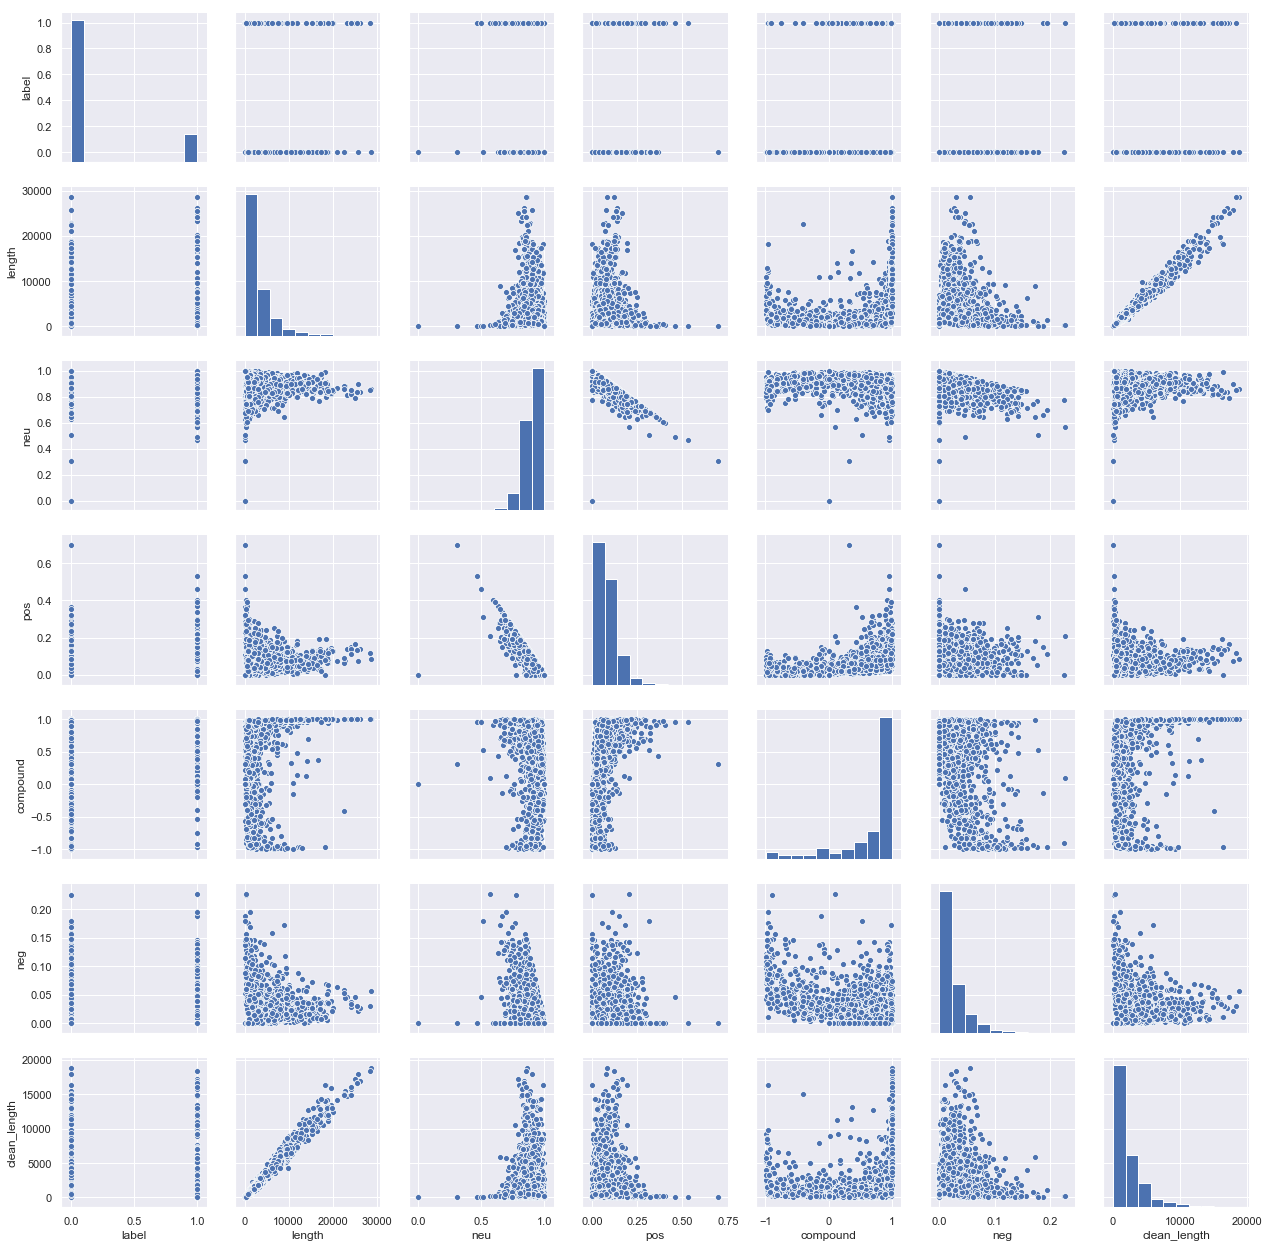

In [95]:
sns.pairplot(df)

AxesSubplot(0.125,0.125;0.775x0.755)


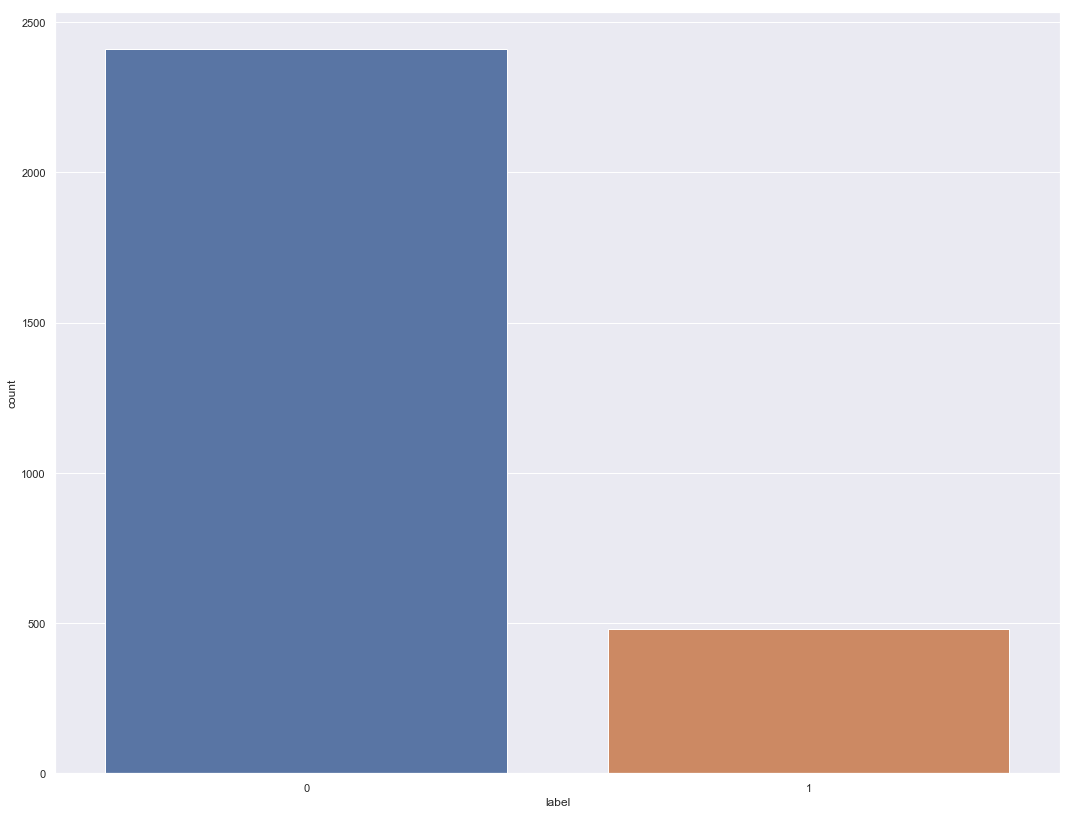

In [41]:
plt.figure(figsize=(18,14))
sns.set()
print(sns.countplot(df.label))

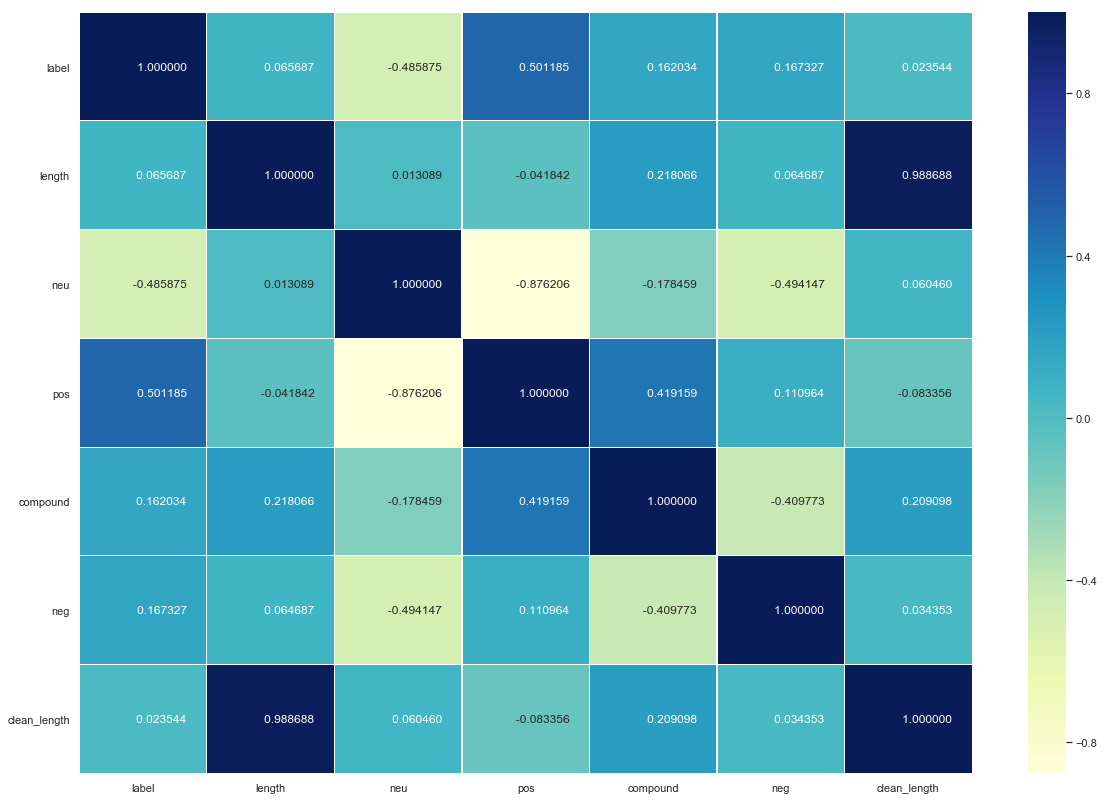

In [96]:
plt.figure(figsize=(20,14))
sns.heatmap(df.corr(),linewidths=.1,fmt="19f",cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

In [61]:
print ('Origian Length', df.length.sum())
print ('Clean Length', df.clean_length.sum())

Origian Length 9344743
Clean Length 6767857


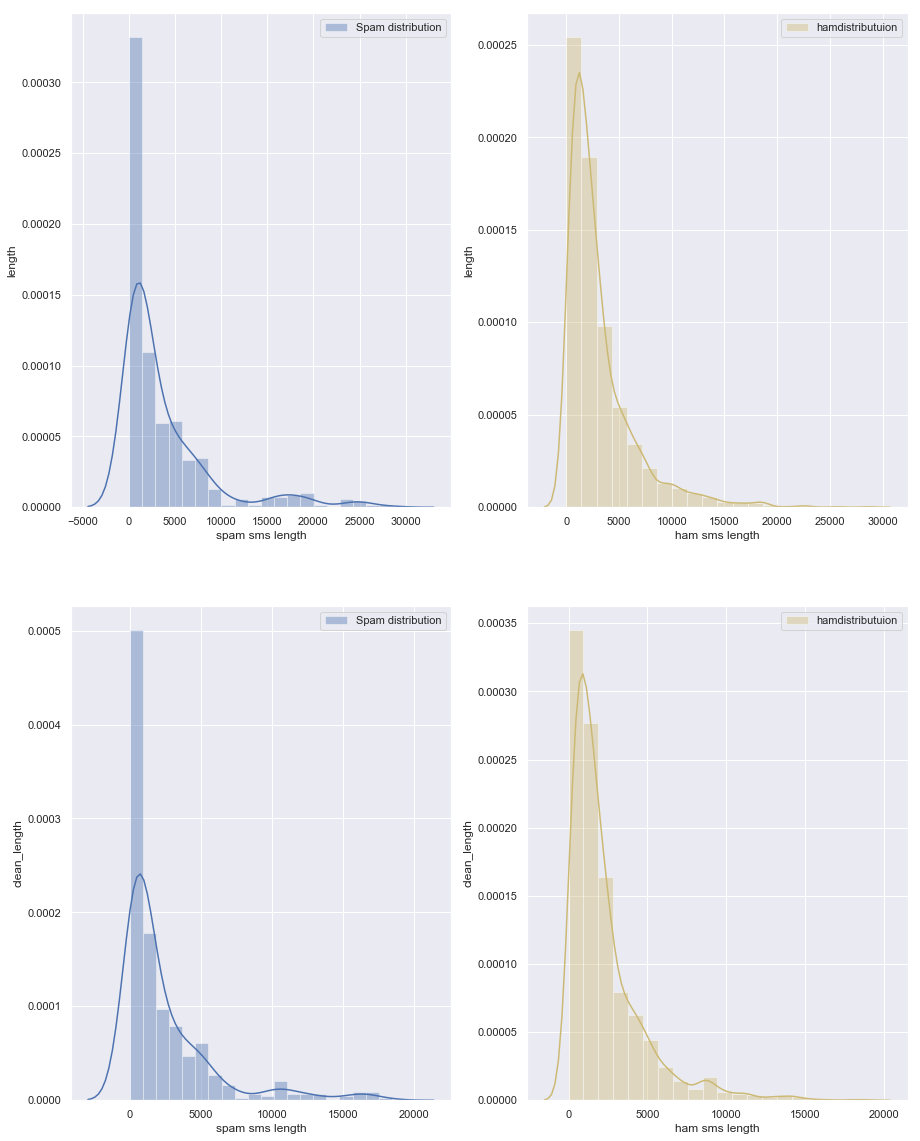

In [62]:
f,ax = plt.subplots(2,2 , figsize =(15,20))
sns.distplot(df[df['label']==1]['length'],bins=20,ax=ax[0,0],label='Spam distribution',color='b')

sns.distplot(df[df['label']==0]['length'],bins=20,ax=ax[0,1],label='hamdistributuion',color='y')
ax[0,0].set_xlabel('spam sms length')
ax[0,1].set_xlabel('ham sms length')
ax[0,0].set_ylabel('length')
ax[0,1].set_ylabel('length')
ax[0,0].legend()
ax[0,1].legend()


sns.distplot(df[df['label']==1]['clean_length'],bins=20,ax=ax[1,0],label='Spam distribution',color='b')

sns.distplot(df[df['label']==0]['clean_length'],bins=20,ax=ax[1,1],label='hamdistributuion',color='y')
ax[1,0].set_xlabel('spam sms length')
ax[1,1].set_xlabel('ham sms length')
ax[1,0].set_ylabel('clean_length')
ax[1,1].set_ylabel('clean_length')
ax[1,0].legend()
ax[1,1].legend()

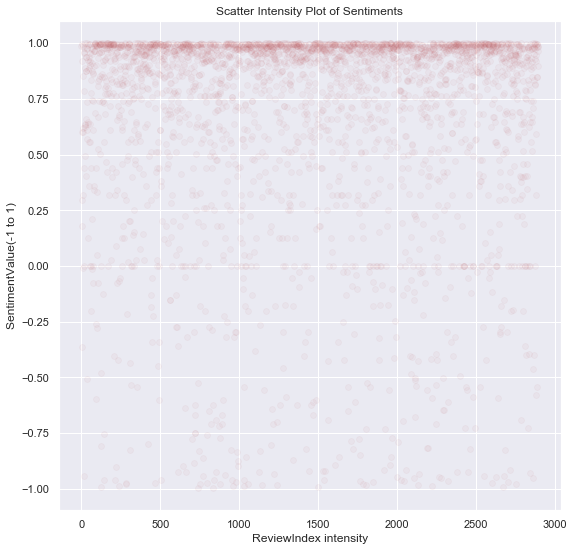

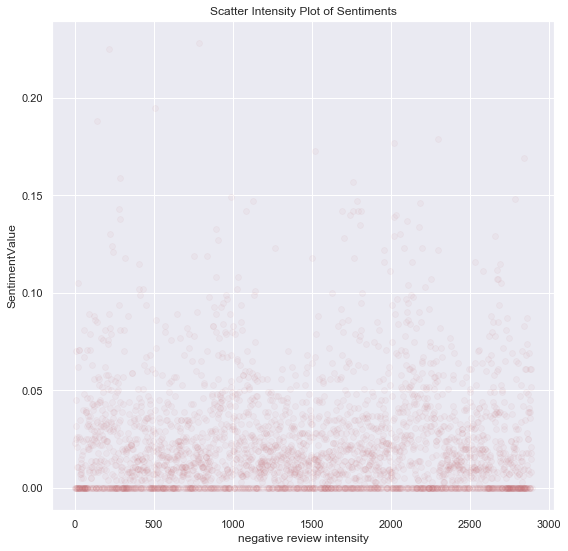

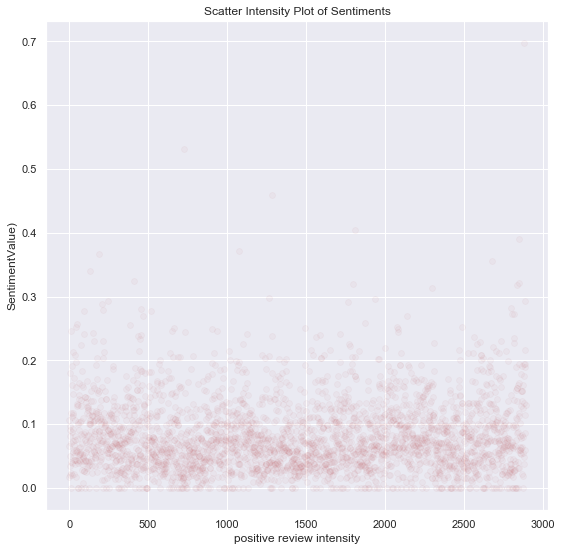

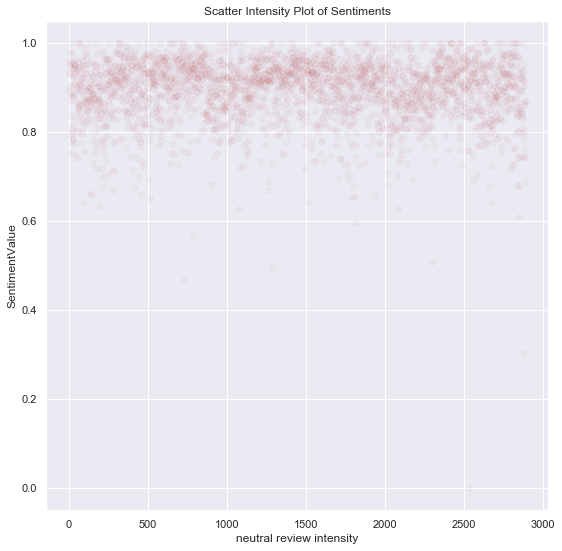

In [83]:
all_sent_values=[]
xaxis = []
for i in range(0,2893):
    xaxis.append(i)
    all_sent_values.append(df['compound'][i])
ylabel_new_1 = all_sent_values[:2893]

xlabel = xaxis
plt.figure(figsize=(9,9))
plt.xlabel('ReviewIndex intensity')
plt.ylabel('SentimentValue(-1 to 1)')
plt.plot(xlabel, ylabel_new_1, 'ro',  alpha=0.04)

plt.title('Scatter Intensity Plot of Sentiments')
plt.show()

all_sent_values=[]
xaxis = []
for i in range(0,2893):
    xaxis.append(i)
    all_sent_values.append(df['neg'][i])
ylabel_new_1 = all_sent_values[:2893]

xlabel = xaxis
plt.figure(figsize=(9,9))
plt.xlabel('negative review intensity')
plt.ylabel('SentimentValue')
plt.plot(xlabel, ylabel_new_1, 'ro',  alpha=0.04)

plt.title('Scatter Intensity Plot of Sentiments')
plt.show()
all_sent_values=[]
xaxis = []
for i in range(0,2893):
    xaxis.append(i)
    all_sent_values.append(df['pos'][i])
ylabel_new_1 = all_sent_values[:2893]

xlabel = xaxis
plt.figure(figsize=(9,9))
plt.xlabel('positive review intensity')
plt.ylabel('SentimentValue)')
plt.plot(xlabel, ylabel_new_1, 'ro',  alpha=0.04)

plt.title('Scatter Intensity Plot of Sentiments')
plt.show()
all_sent_values=[]
xaxis = []
for i in range(0,2893):
    xaxis.append(i)
    all_sent_values.append(df['neu'][i])
ylabel_new_1 = all_sent_values[:2893]

xlabel = xaxis
plt.figure(figsize=(9,9))
plt.xlabel('neutral review intensity')
plt.ylabel('SentimentValue')
plt.plot(xlabel, ylabel_new_1, 'ro',  alpha=0.04)

plt.title('Scatter Intensity Plot of Sentiments')
plt.show()

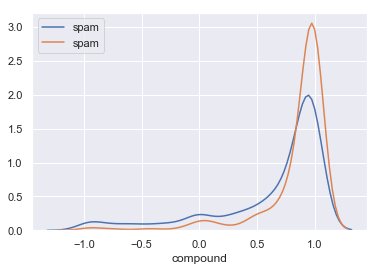

In [85]:
for x in [0,1]:
    subset = df[df['label'] == x]
    
    # Draw the density plot
    if x == '0':
        label = "valid mail"
    else:
        label = "spam"
    sns.distplot(subset['compound'], hist = False, label = label)

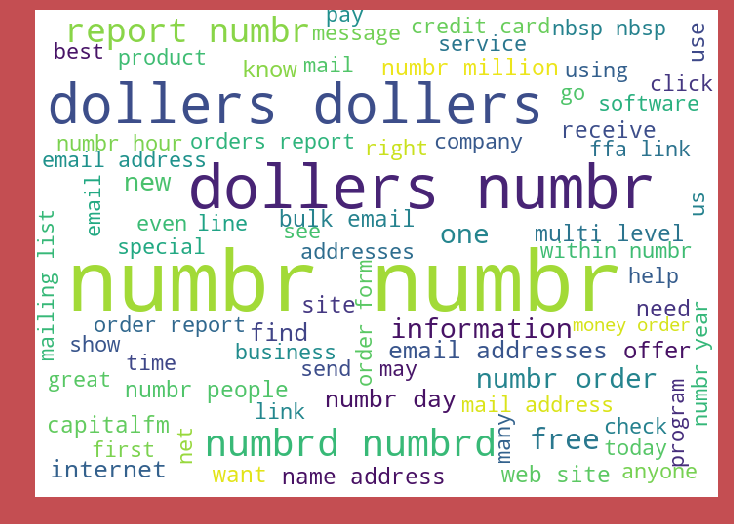

In [75]:
from wordcloud import WordCloud


spams = df['message1'][df['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=75).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

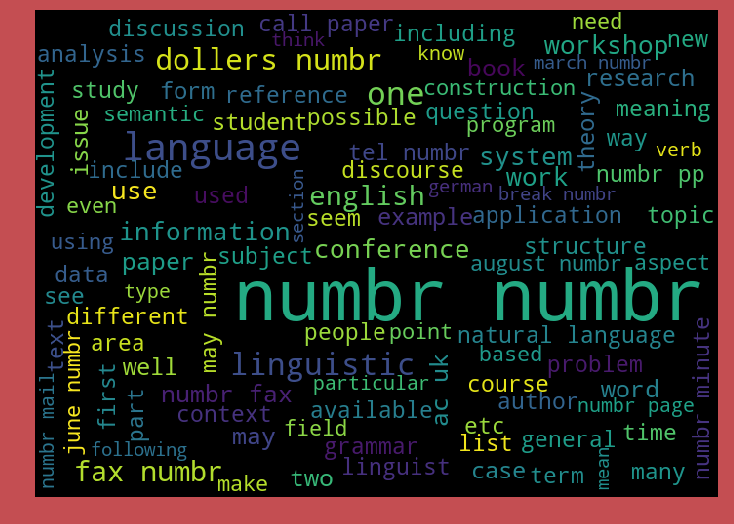

In [74]:
spams = df['message1'][df['label']==0]

spam_cloud = WordCloud(width=700,height=500,background_color='black',max_words=100).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Modelling reviewer_score

In [68]:
naive = MultinomialNB()
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm = SVC(random_state = 1)
dtc = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors = 2)
model = LogisticRegression()
z=[naive,rf,svm,dtc,knn,model]

final score MultinomialNB() with TfidfVectorizer() = > 0.81353591160221
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       585
           1       1.00      0.03      0.06       139

    accuracy                           0.81       724
   macro avg       0.91      0.51      0.48       724
weighted avg       0.85      0.81      0.74       724



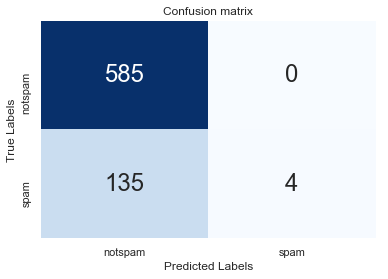

final score RandomForestClassifier(random_state=42) with TfidfVectorizer() = > 0.9709944751381215
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       585
           1       1.00      0.85      0.92       139

    accuracy                           0.97       724
   macro avg       0.98      0.92      0.95       724
weighted avg       0.97      0.97      0.97       724



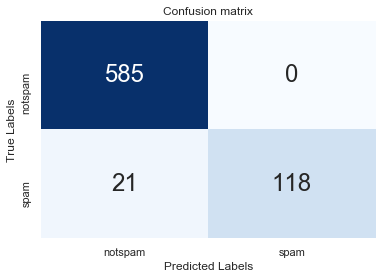

final score SVC(random_state=1) with TfidfVectorizer() = > 0.9834254143646409
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       585
           1       1.00      0.91      0.95       139

    accuracy                           0.98       724
   macro avg       0.99      0.96      0.97       724
weighted avg       0.98      0.98      0.98       724



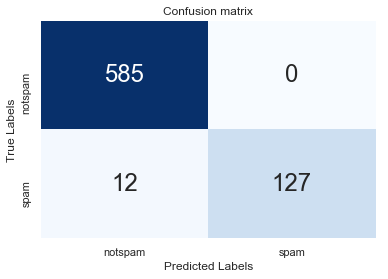

final score DecisionTreeClassifier() with TfidfVectorizer() = > 0.9668508287292817
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       585
           1       0.95      0.87      0.91       139

    accuracy                           0.97       724
   macro avg       0.96      0.93      0.94       724
weighted avg       0.97      0.97      0.97       724



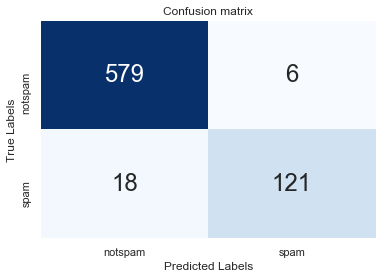

final score KNeighborsClassifier(n_neighbors=2) with TfidfVectorizer() = > 0.8701657458563536
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       585
           1       1.00      0.32      0.49       139

    accuracy                           0.87       724
   macro avg       0.93      0.66      0.71       724
weighted avg       0.89      0.87      0.84       724



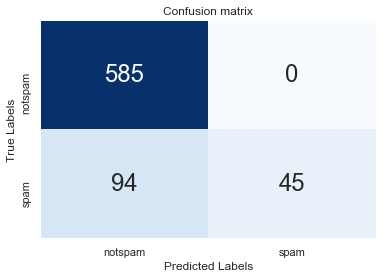

final score LogisticRegression() with TfidfVectorizer() = > 0.9737569060773481
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       585
           1       1.00      0.86      0.93       139

    accuracy                           0.97       724
   macro avg       0.98      0.93      0.96       724
weighted avg       0.97      0.97      0.97       724



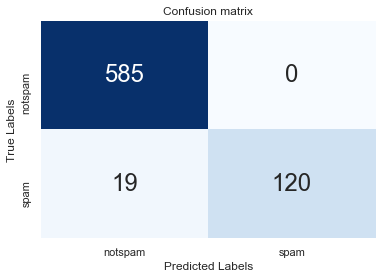

final score MultinomialNB() with CountVectorizer() = > 0.9903314917127072
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       585
           1       0.96      0.99      0.98       139

    accuracy                           0.99       724
   macro avg       0.98      0.99      0.98       724
weighted avg       0.99      0.99      0.99       724



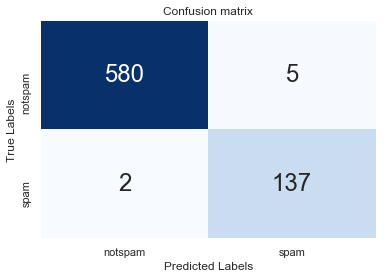

final score RandomForestClassifier(random_state=42) with CountVectorizer() = > 0.9737569060773481
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       585
           1       1.00      0.86      0.93       139

    accuracy                           0.97       724
   macro avg       0.98      0.93      0.96       724
weighted avg       0.97      0.97      0.97       724



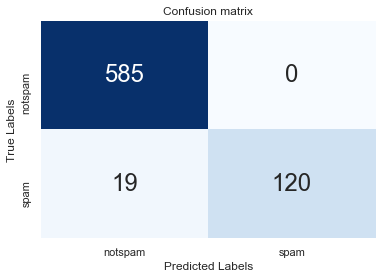

final score SVC(random_state=1) with CountVectorizer() = > 0.9323204419889503
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       585
           1       1.00      0.65      0.79       139

    accuracy                           0.93       724
   macro avg       0.96      0.82      0.87       724
weighted avg       0.94      0.93      0.93       724



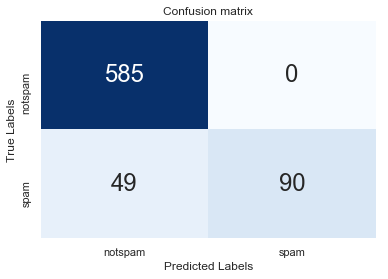

final score DecisionTreeClassifier() with CountVectorizer() = > 0.9751381215469613
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       585
           1       0.95      0.92      0.93       139

    accuracy                           0.98       724
   macro avg       0.96      0.95      0.96       724
weighted avg       0.97      0.98      0.97       724



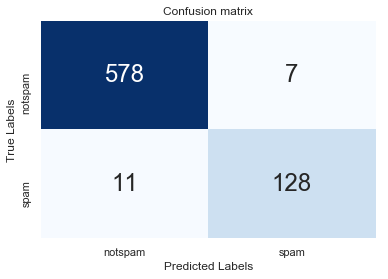

final score KNeighborsClassifier(n_neighbors=2) with CountVectorizer() = > 0.9461325966850829
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       585
           1       0.98      0.73      0.84       139

    accuracy                           0.95       724
   macro avg       0.96      0.87      0.90       724
weighted avg       0.95      0.95      0.94       724



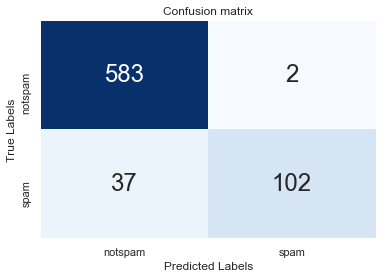

final score LogisticRegression() with CountVectorizer() = > 0.9930939226519337
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       585
           1       0.99      0.97      0.98       139

    accuracy                           0.99       724
   macro avg       0.99      0.98      0.99       724
weighted avg       0.99      0.99      0.99       724



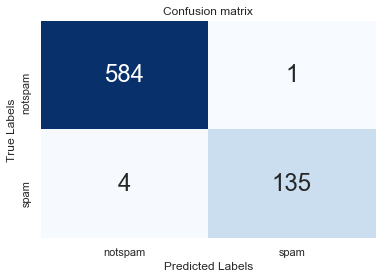

In [69]:
tf_vec = TfidfVectorizer()
vect1 = CountVectorizer(ngram_range=(1,1))
model1=[]
accuracy_score1 =[]
s=[tf_vec,vect1]
for k in s:
    X = df.loc[:,('message')]

    features = k.fit_transform(X)

    X = features
    y = df['label']
    X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)
    for i in z:
        i.fit(X_train,Y_train)
        y_pred = i.predict(x_test)
        print('final score {} with {} = >' .format(i,k),accuracy_score(y_test,y_pred))
        x=(' {}  {}' .format(i,k))
        model1.append(x)
        print(classification_report(y_test, y_pred))
        accuracy_score1.append(accuracy_score(y_test,y_pred))
        
        conf_mat = confusion_matrix(y_test,y_pred)
        conf_mat = confusion_matrix(y_test,y_pred)

        ax=plt.subplot()
        
        sns.heatmap(conf_mat,ax=ax,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
        #sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)
        ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

        ax.set_title('Confusion matrix')
        ax.xaxis.set_ticklabels(['notspam','spam'])
        ax.yaxis.set_ticklabels(['notspam','spam'])
        plt.show()


# Model Selection/Conclusion

In [70]:
df1 = pd.DataFrame(list(zip(model1, accuracy_score1)), 
               columns =['model1', 'accuracy_score1']) 
df1 

model1  accuracy_score1
0                  MultinomialNB()  TfidfVectorizer()         0.813536
1    RandomForestClassifier(random_state=42)  Tfid...         0.970994
2              SVC(random_state=1)  TfidfVectorizer()         0.983425
3         DecisionTreeClassifier()  TfidfVectorizer()         0.966851
4    KNeighborsClassifier(n_neighbors=2)  TfidfVec...         0.870166
5             LogisticRegression()  TfidfVectorizer()         0.973757
6                  MultinomialNB()  CountVectorizer()         0.990331
7    RandomForestClassifier(random_state=42)  Coun...         0.973757
8              SVC(random_state=1)  CountVectorizer()         0.932320
9         DecisionTreeClassifier()  CountVectorizer()         0.975138
10   KNeighborsClassifier(n_neighbors=2)  CountVec...         0.946133
11            LogisticRegression()  CountVectorizer()         0.993094

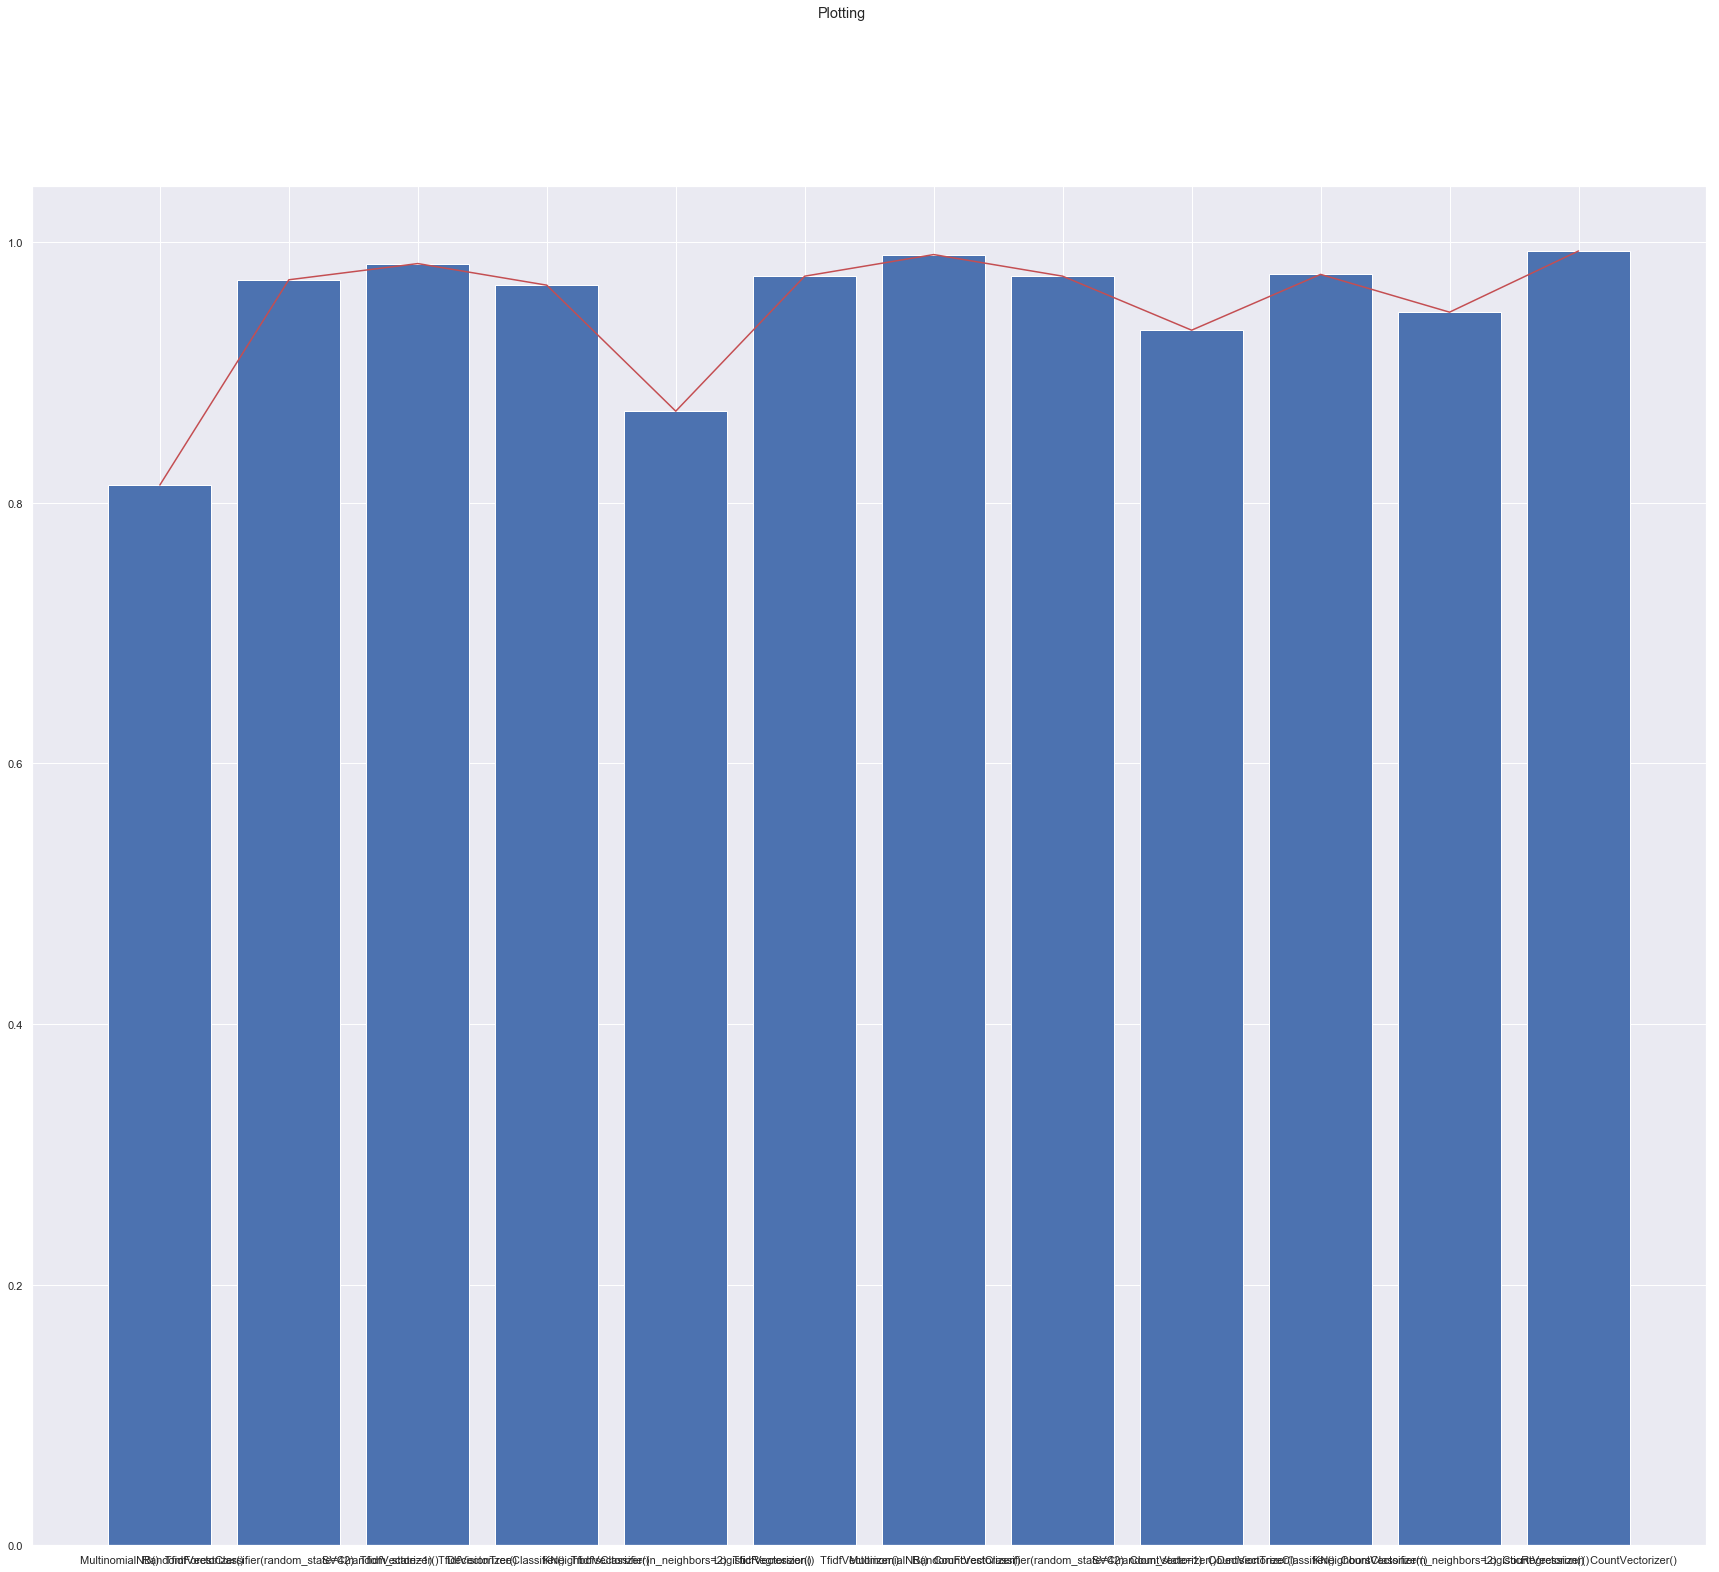

In [73]:
plt.figure(figsize=(30,25))
plt.plot(model1, accuracy_score1,c='r')
plt.bar(model1, accuracy_score1)
plt.suptitle('Plotting')

plt.show()

# The best regression model for this is LogisticRegression() CountVectorizer()	with accuracy score is 0.993094